In [1]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  series = tf.expand_dims(series, axis=-1)
  ds = Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(batch_size + 1))
  ds = ds.shuffle(shuffle_buffer_size).map(lambda x: (x[:-1], x[-1:]))
  ds = ds.batch(batch_size).prefetch(1)

  return ds

In [24]:
train_set = windowed_dataset(x_train, window_size,batch_size,shuffle_buffer_size)
model = Sequential([
                    Conv1D(32,kernel_size=5,strides=1, padding='causal', activation='relu', input_shape=[None,1]),
                    Bidirectional(LSTM(32, return_sequences=True)),
                    Bidirectional(LSTM(32, return_sequences=True)),
                    Dense(1),
                    Lambda(lambda x: x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 12ms/step - loss: 46.3587 - mae: 46.8576 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 41.1802 - mae: 41.6790 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 37.2990 - mae: 37.7970 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 33.6348 - mae: 34.1323 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 30.2832 - mae: 30.7792 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 27.6165 - mae: 28.1124 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 25.5971 - mae: 26.0929 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 24.1195 - mae: 24.6159 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 22.8888 - mae:

(1e-08, 0.001, 0.0, 100.0)

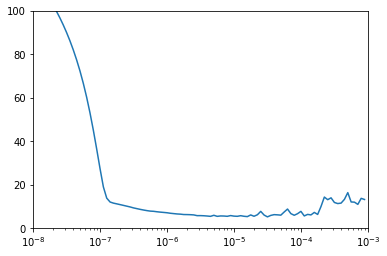

In [6]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8, 1e-3, 0,100 ])

In [32]:
model = Sequential([
                    Conv1D(32,kernel_size=3,strides=1, padding='causal', activation='relu', input_shape=[None,1]),
                    LSTM(32, return_sequences=True),
                    LSTM(32, return_sequences=True),
                    Dense(1),
                    Lambda(lambda x: x * 200.0)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
31/31 [==============================] - 0s 6ms/step - loss: 17.3371 - mae: 17.8323
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 11.7410 - mae: 12.2304
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 9.2674 - mae: 9.7541
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 8.7179 - mae: 9.2041
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 10.6993 - mae: 11.1885
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 8.8842 - mae: 9.3708
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 8.5437 - mae: 9.0293
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 8.1325 - mae: 8.6188
Epoch 9/500
31/31 [==============================] - 0s 7ms/step - loss: 10.2337 - mae: 10.7238
Epoch 10/500
31/31 [==============================] - 0s 7ms/step - loss: 8.2416 - mae: 8.7267
Epoch 11/500
31/31 [==============================]

In [132]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    #1 batch of ds will be of shape (32,20,1) corresponding to 32 examples per batch, 20 values per example and it being 1 big batch
    forecast = model.predict(ds)
    return forecast,ds

In [146]:
mez = model.predict(me)

In [148]:
mez.shape

(32, 20, 1)

In [149]:
me.shape

TensorShape([32, 20, 1])

In [142]:
for i in dez.take(1):
  me = i

In [140]:
forecast_series = np.expand_dims(series, axis=-1)
rnn_forecast,dez = model_forecast(model, forecast_series, window_size)

In [139]:
rnn_forecast.shape

(1442, 20, 1)

In [152]:
rnn_forecast[split_time - window_size,-1,0]

64.42212

In [41]:
val_pred = rnn_forecast[split_time - window_size:-1, -1, 0]

In [131]:
val_pred

array([59.786217, 60.648502, 62.412716, 62.564957, 61.320293, 62.20218 ,
       62.54604 , 62.23175 , 63.04545 , 61.797737, 60.007713, 60.50402 ,
       61.914944, 61.853237, 58.304287, 61.747932, 61.39859 , 62.609818,
       61.350334, 62.41027 , 61.667526, 60.82046 , 61.36585 , 60.961956,
       61.598225, 63.358097, 64.81205 , 63.473164, 63.002365, 63.40247 ,
       62.71585 , 61.881256, 58.689415, 59.717583, 58.84832 , 60.26358 ,
       59.590828, 57.1048  , 59.01267 , 59.186615, 59.683228, 60.728676,
       60.857296, 62.7313  , 62.581802, 63.27628 , 62.869446, 63.161404,
       57.965015, 59.162277, 60.79572 , 61.7863  , 62.248672, 63.189644,
       63.549202, 60.575706, 60.784393, 60.787582, 62.422657, 63.34045 ,
       62.733322, 62.53764 , 57.18419 , 59.516125, 56.162464, 57.29417 ,
       57.96367 , 60.005848, 58.74722 , 59.265373, 60.450466, 62.08103 ,
       62.099277, 62.157707, 61.09972 , 60.66195 , 62.562275, 61.689407,
       60.52834 , 58.953964, 60.497208, 63.037567, 

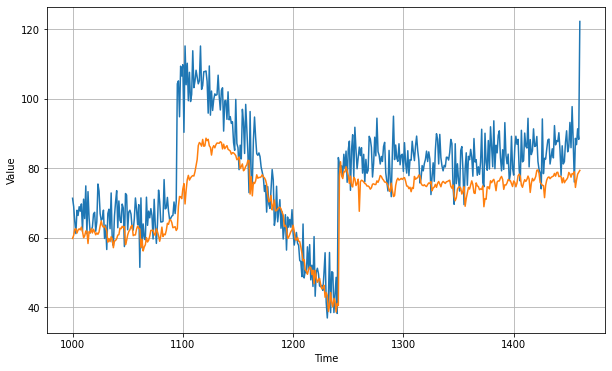

In [46]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, val_pred)